## Fetching Data, Imports, Load CSV

In [ ]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.193 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18599/1236839/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605342864&Signature=EnlHY9DVWLCrCG3Pq5%2BgOpZ5ci%2Bl%2FKz0BEsVVDVArUb9SJLMH24iEQ%2FwF3dELdUj1IoUWxhz7%2BRUaMJDLEoMfoHH28pWgcH0BpHwpC6ODo9dgw8gT5rEJJ%2FerJQW7ALQHxRT2OlMDjYgKZuqlO0D53K9iUjqbHcRwNTR0aOlAyB7coNuJfVfUOCyQhksene0O1rNi4FlUOpSLWcbe9IogPeeOGDLFGmdiS1wHVo4H5cVrNgcuehj8PcSTLZU9UbE7oHRacs8jUz7CKUPU3NgEQ76eWcvb%2Bu46rBWJvu%2BD51fq%2BX0me7ysMizf0HQ7xLoTLTqc7loAqaaW3hEy3k5sw%3D%3D&response-content-disposition=attachment%3B+filename%3Dm5-forecasting-accuracy.zip" -c -O 'm5-forecasting-accuracy.zip'

In [ ]:
# !unzip m5-forecasting-accuracy.zip

# !apt-get update
# !apt-get install wget

# ! pip install pandas
# ! pip install calender
# ! pip install numpy
# ! pip install datetime
# ! pip install matplotlib
# ! pip install collections
# ! pip install random
# ! pip install tqdm
# ! pip install sklearn
# ! pip install lightgbm

In [ ]:
from IPython.display import clear_output 
import pandas as pd
import calendar
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output as cclear
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
import lightgbm as lgb
from math import sqrt
from itertools import zip_longest
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randFloat
import joblib
import xgboost as xgb

import myfeature

def get_csv(X):
    return pd.read_csv(X)

calender, sales_train_ev, sales_train_val, sell_prices, samp_sub = get_csv('calendar.csv'), \
                          get_csv('sales_train_evaluation.csv'), \
                          get_csv('sales_train_validation.csv'), get_csv('sell_prices.csv'), \
                          get_csv('sample_submission.csv')

## Training Functions

In [ ]:
non_numeric_col_list = ['id','item_id','dept_id','cat_id','store_id','state_id','d', 'date']
store_dict = {'CA_1':0, 'CA_2':0, 'CA_3':0, 'CA_4':0, 'WI_1':0, 'WI_2':0, 'WI_3':0, 'TX_1':0, 'TX_2':0, 'TX_3':0}

days_with_event = []
for i in range(len(calender)):
    days_with_event.append(event1_check(i)) or (event2_check(i))
    
l = [int(i) for i in days_with_event]
event_dict = dict(zip(calender.d, l))

week_no_d_dict = dict(zip(calender.wm_yr_wk, calender.d))
sell_prices['d'] = sell_prices['wm_yr_wk'].map(week_no_d_dict)
sell_prices['item_d_col'] = sell_prices['item_id'] + sell_prices['d']
sale_price_dict = dict(zip(sell_prices['item_d_col'], sell_prices['sell_price']))

sell_prices = sell_prices.drop('d', 1)
sell_prices = sell_prices.drop('item_d_col', 1)

## Different Training Strategies

### Words on Train Test Split

We want to predict 28 days under labels F1-F28. These 28 days are like this for evaluation and validation dataset.
<br>For evaluation dataset predict d_1942 - d_1969
<br>For validation dataset predict d_1914 - d_1941

### Training strategy 0.1

In [ ]:
# First score is Private and second score is Public score

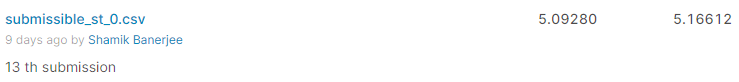

In this strategy we train on one year data only, so for eval data we train on 1941-365 to 1941 and for val data we train on 1913-365 to 1913 test on 1941 to 1969 for evaluation data and we test on 1913 to 1941 for validation data. 

However we use four models to predict 28 days. First model predicts week1, second predicts week1 and week2, third predicts week1, week2, week3 and fourth model predicts week1, week2, week3, week4. Then we append 0 s to make all these predicted lists same length and then we take element wise mean to make the final prediction.

Though a good concept, it did not do well during submission.

In [ ]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, \
                                                                3049*(1913-365), 3049*1913
strategy = 0.1
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y(df, store_name) # this fun selects rows for given store name, adds more columns, 
                                           # does encoding, returns X and y and encoder

    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data
        # for plotting prediction
        # X_train, y_train = X.iloc[3049*(1913-365):3049*1913], y[3049*(1913-365):3049*1913]
        # X_test, y_test = X.iloc[3049*1913:], y[3049*1913:]
        
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:] 
    
    if df.id.iloc[0].find('validation') != -1:  # if validation data
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    model = [0]*4
    for i in range(4):
        model[i] = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)

    print("One of 4 models fitting....")
    model[0].fit(X_train, y_train)
    train_out_week1 = model[0].predict(X_test.iloc[(0*3049):(7*3049)])
    
    print("Two of 4 models fitting....")
    model[1].fit(X_train, y_train)
    train_out_week12 = model[1].predict(X_test.iloc[(0*3049):(14*3049)])
    
    print("Three of 4 models fitting....")
    model[2].fit(X_train, y_train)
    train_out_week123 = model[2].predict(X_test.iloc[(0*3049):(21*3049)])
    
    print("Four of 4 models fitting....")
    model[3].fit(X_train, y_train)
    train_out_week1234 = model[3].predict(X_test.iloc[(0*3049):(28*3049)])
    
    train_out = [np.mean(n) for n in zip_longest(train_out_week1, train_out_week12, train_out_week123, train_out_week1234\
                                          , fillvalue=0)]
    
    return le, X_test, y_test, train_out

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [ ]:
# %%time

# ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365), 3049*1913, \
#                                                                 _, _
# strategy = 0.1

# df = sales_train_ev.copy()
# empty_list = [0]*30490
# for i in range(1942, 1970):
#     df['d_'+str(i)] = empty_list
# df = feature_engineer(df)

# le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
# out_df = reverse_long_form(le, X_test, train_out)
# out_df.head(5)

# ########################################################################################################################
# # 4 min

In [ ]:
plt.plot(list(y_test))
plt.plot(list(train_out))
plt.legend(['true label', 'predicted labels'])
plt.title('Prediction of unit sales for 1914 to 1941 in long form')
plt.xlabel('Index of sales_train_ev in long form after adding 1942 to 1969 columns')
plt.ylabel("Units sold")
plt.show()

### Training strategy 0.2

In [ ]:
# First score is Private and second score is Public score

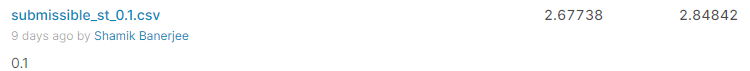

We do not test code for this one as only differece from 0.1 model is that this one fits entire val data
and previous one took only one year of val data.

In [ ]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(0), 3049*1913
strategy = 0.1
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = myfeature.get_X_and_y_withou_adding_more_features(df, store_name)

    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data
        # for plotting prediction
        # X_train, y_train = X.iloc[3049*(1913-365):3049*1913], y[3049*(1913-365):3049*1913]
        # X_test, y_test = X.iloc[3049*1913:], y[3049*1913:]
        
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:] 
    
    if df.id.iloc[0].find('validation') != -1:  # if validation data
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    model = [0]*4
    for i in range(4):
        model[i] = LGBMRegressor(num_leaves=1100, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 1418)

    model[0].fit(X_train, y_train)
    train_out_week1 = model[0].predict(X_test.iloc[(0*3049):(7*3049)])
    
    model[1].fit(X_train, y_train)
    train_out_week12 = model[1].predict(X_test.iloc[(0*3049):(14*3049)])
    
    model[2].fit(X_train, y_train)
    train_out_week123 = model[2].predict(X_test.iloc[(0*3049):(21*3049)])
    
    model[3].fit(X_train, y_train)
    train_out_week1234 = model[3].predict(X_test.iloc[(0*3049):(28*3049)])
    
    train_out = [np.mean(n) for n in zip_longest(train_out_week1, train_out_week12, train_out_week123, train_out_week1234\
                                          , fillvalue=0)]
    
    return le, X_test, y_test, train_out

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [ ]:
# %%time

# ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365), 3049*1913, \
#                                                                 _, _
# strategy = 0.1

# df = sales_train_ev.copy()
# empty_list = [0]*30490
# for i in range(1942, 1970):
#     df['d_'+str(i)] = empty_list
# df = feature_engineer(df)

# le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
# out_df = reverse_long_form(le, X_test, train_out)
# out_df.head(5)

##################################################################################################################
# 4 min


### Training strategy 1 - Ignore

As it is very complex, this one could not be run on my machine. So we move on to second simpler method.
This one should be ignored.

Training strategy used in fit_fun_2():
<br>Train on data till 1829, predict on X_test of 1829 to 1857. Now for this prediction we will use 4 models, each model will predict one week of the 28 days of test data. This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

This is repeated for next test sets as described below.

Train on data till 1857, predict on X_test of 1858 to 1885. Now for this prediction we will use 4 models, each model will predict one week of the 28 days of test data.This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

Train on data till 1885, predict on X_test of 1886 to 1913. Now for this prediction we will use 4 models, each model will predict one week of the 28 days of test data.This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

Train on data till 1913, predict on X_test of 1914 to 1941. Now for this prediction we will use 4 models, each model will predict one week of the 28 days of test data. This prediction is ultimate prediction for this store.

change: we kept only last two stages in code, only 1886 to 1913 and 1913 to 1941, but it could not be run.

In [ ]:
# This function takes input which year to which year should be test data and returns extended y_train or train_out 
# as necessary.

def year_wise_train_test(X, y, y_train, start, end):
    X_train, X_test = X.iloc[0:(3049*start)], X.iloc[(3049*start):(3049*end)] 
    y_test = y[(3049*start):(3049*end)]

    if y_train==1:
        y_train = y[0:(3049*start)]
        
    train_out = []
    for i in range(4):
        print('Predicting week ', i)
        model = LGBMRegressor(objective = 'tweedie', num_leaves=588, learning_rate=0.67, reg_lambda=0.78, \
                              n_estimators= 363, min_data_in_leaf= 906)
        model.fit(X_train, y_train)
        train_out.extend(list( model.predict(X_test.iloc[(i*7*3049):((i+1)*7*3049)] )))
    
    y_train = list(y_train)
    
    if (start == 1913) and (end==1941):
        return y_train, X_test, y_test, train_out
    else:    
        y_train.extend(list(train_out))
        return y_train
strategy = 1

def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = myfeature.get_X_and_y(df, store_name)      # this fun selects rows for given store name, adds more columns, 
                                                # does encoding, returns X and y and encoder
    
    print('Testing on 1885 to 1913...')
    y_train = year_wise_train_test(X, y, 1, 1885, 1913)
    
    print('Testing on 1913 to 1941...')
    y_train, X_test, y_test, train_out = year_wise_train_test(X, y, y_train, 1913, 1941)
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data
        print('Testing on 1941 to 1969...')
        y_train, X_test, y_test, train_out = year_wise_train_test(X, y, y_train, 1941, 1969)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [ ]:
# %%time
# df = sales_train_ev.copy()  # estimated 37 seconds to run
# df = feature_engineer(df)

# le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
# mse(train_out, y_test)
########################################################################################################################

### Training strategy 2 - Ignore

This method is fairly complex, it did well while training but submission scores were extremely bad.
As this method predicts on prediction I am moving forward to other methods leaving this one.

Training strategy used in fit_fun_2():
<br>Train on data till 1829, predict on X_test of 1829 to 1857. This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

Train on data till 1857, predict on X_test of 1858 to 1885. This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

Train on data till 1885, predict on X_test of 1886 to 1913. This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

Train on data till 1913, predict on X_test of 1914 to 1941. This prediction is ultimate prediction for this store.

In [ ]:
# This function takes input which year to which year should be test data and returns extended y_train or train_out 
# as necessary.

def year_wise_train_test(X, y, y_train, model, start, end):
    X_train, X_test = X.iloc[0:(3049*start)], X.iloc[(3049*start):(3049*end)] 
    y_test = y[(3049*start):(3049*end)]

    if y_train==1:
        y_train = y[0:(3049*start)]
        
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    y_train = list(y_train)
    
    if ((start == 1913) and (end==1941)) or ((start == 1941) and (end==1969)):
        return y_train, X_test, y_test, train_out
    else:    
        y_train.extend(list(train_out))
        return y_train
strategy = 2
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y(df, store_name)      # this fun selects rows for given store name, adds more columns, 
                                                # does encoding, returns X and y and encoder
    
    model = LGBMRegressor(objective = 'tweedie', num_leaves=588, learning_rate=0.67, reg_lambda=0.78, \
                              n_estimators= 363, min_data_in_leaf= 906)
    
    print('Testing on 1829 to 1857...')
    y_train = year_wise_train_test(X, y, 1, model, 1829, 1857)
    
    print('Testing on 1857 to 1885...')
    y_train = year_wise_train_test(X, y, y_train, model, 1857, 1885)
    
    print('Testing on 1885 to 1913...')
    y_train = year_wise_train_test(X, y, y_train, model, 1885, 1913)
    
    print('Testing on 1913 to 1941...')
    y_train, X_test, y_test, train_out = year_wise_train_test(X, y, y_train, model, 1913, 1941)
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data
        print('Testing on 1941 to 1969...')
        y_train, X_test, y_test, train_out = year_wise_train_test(X, y, y_train, model, 1941, 1969)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [ ]:
%%time
df = sales_train_ev.copy()  # estimated 37 seconds to run
df = myfeature.feature_engineer(df)

le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')  # estimated time to run 3 minute 15 seconds
mse(train_out, y_test) # 8.55 for CA_1
############################################################################################################################

### Training strategies 3.1, 3.2, 3.3, 3.4, 3.5, 3.6

In [ ]:
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = myfeature.get_X_and_y_withou_adding_more_features(df, store_name)
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # X_train, y_train = X.iloc[0:3049*1941], y[:3049*1941]
        # X_test, y_test = X.iloc[3049*1941:], y[3049*1941:]

        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     

    if df.id.iloc[0].find('validation') != -1:  # if validation data
        
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

#### Training strategy - 3.1

In [ ]:
# First score is Private and second score is Public score

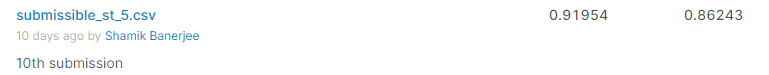

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on only one year of data (1576 to 1941) and predicts 1942 to 1969. 
<br>But for validation it fits on entire data till 1913 and predicts 1914 to 1941.

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(0), 3049*1913
strategy = 5

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [ ]:
# # %%time
# df = sales_train_ev.copy()
# empty_list = [0]*30490
# for i in range(1942, 1970):
#     df['d_'+str(i)] = empty_list
# df = feature_engineer(df)

# ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365), 3049*1913, _, _
# le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
# out_df = reverse_long_form(le, X_test, train_out)

# # ##########################################################################################################################
# # # Estimated time to run 2 min

In [ ]:
myfeature.plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

#### Training Strategy - 3.2

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on only one year of data (1576 to 1941) and predicts 1942 to 1969. 
<br>For validation again it fits on one year data 1913-365 to 1913.

In [ ]:
# First score is Private and second score is Public score

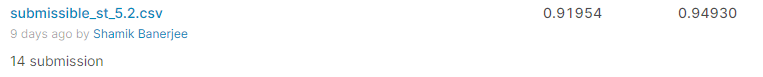

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(1913-365), 3049*1913
strategy =5.2

#### Training Strategy - 3.3

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on three years of data (1941-365-365-365 to 1941) and predicts 1942 to 1969. 
<br>For validation again it fits on three years data 1913-365-365-365 to 1913.

In [ ]:
# First score is Private and second score is Public score

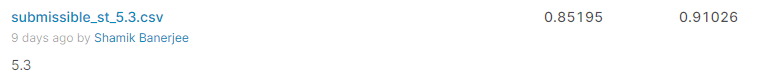

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365-365-365), 3049*1941, \
                                                                3049*(1913-365-365-365), 3049*1913
strategy = 5.3

In [ ]:
# %%time
df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = myfeature.feature_engineer(df)

ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365-365-365), 3049*1913, _, _
le, X_test, y_test, train_out = myfeature.fit_fun_2(df, 'CA_1')
out_df = myfeature.reverse_long_form(le, X_test, train_out)

# ##########################################################################################################################
# # Estimated time to run 2 min

myfeature.plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

#### Training Strategy -  3.4

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on entire data (0 to 1941) and predicts 1942 to 1969. 
<br>For validation again it fits on entire data 0 to 1913.

In [ ]:
# First score is Private and second score is Public score

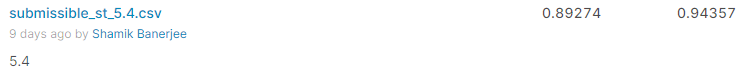

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(0), 3049*1941, \
                                                                3049*(0), 3049*1913
strategy = 5.4

In [ ]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(0), 3049*1913, _, _
le, X_test, y_test, train_out = myfeature.fit_fun_2(df, 'CA_1')
out_df = myfeature.reverse_long_form(le, X_test, train_out)

# ##########################################################################################################################
# # Estimated time to run 2 min

myfeature.plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

#### Training Strategy - 3.5

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on two years data (1941-365-365 to 1941) and predicts 1942 to 1969. 
<br>For validation again it fits on entire data 0 to 1913.

In [ ]:
# First score is Private and second score is Public score

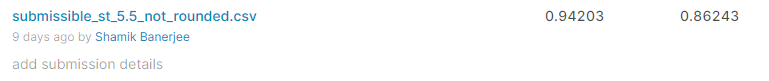

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365-365), 3049*1941, \
                                                                3049*(0), 3049*1913
strategy = 5.5

In [ ]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365-365), 3049*1913, _, _
le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
out_df = myfeature.reverse_long_form(le, X_test, train_out)

# ##########################################################################################################################
# # Estimated time to run 2 min

myfeature.plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

#### Training Strategy - 3.6

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on three years data (1941-365-365-365 to 1941) and predicts 1942 to 1969. 
<br>For validation again it fits on entire data 0 to 1913.

In [ ]:
# First score is Private and second score is Public score

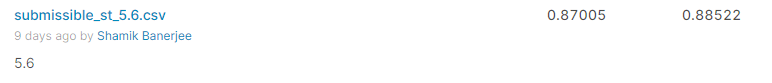

In [ ]:
model = LGBMRegressor(num_leaves=1100, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 1418)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365-365-365), 3049*1941, \
                                                                3049*(0), 3049*1913
strategy = 5.6

In [ ]:
model = LGBMRegressor(num_leaves=1100, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 1418)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365-365-365), 3049*1913, _, _
le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
out_df = myfeature.reverse_long_form(le, X_test, train_out)

# ##########################################################################################################################
# # Estimated time to run 2 min

myfeature.plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

### Training strategy 4

#### Training Strategy 4.1

In [ ]:
# First score is Private and second score is Public score

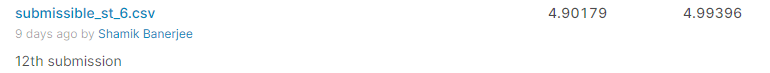

In this strategy we add all the columns we can add. Then we fit on one year of data only, both for eval and val data.
<br>For eval we train on 1941-365 to 1941, we test on 1941 to 1969.
<br>For val we train on 1913-365 to 1913 and we test on 1913 to 1969.

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(1913-365), 3049*1913
strategy = 6
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = myfeature.get_X_and_y(df, store_name)      # this fun selects rows for given store name, adds more columns, 
                                                # does encoding, returns X and y and encoder
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # following code can be used to predict on 1913 to 1969 to plot true and predict of 1913 to 1941
        # X_train, y_train = X.iloc[3049*(1941-365-365-365):3049*1913], y[3049*(1941-365-365-365):3049*1913]
        # X_test, y_test = X.iloc[3049*1913:], y[3049*1913:]                     
        
        # Original code for fitting, fitiing only on 3 years data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     
    
    if df.id.iloc[0].find('validation') != -1:  # if validation data
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    print('Fitting...')
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [ ]:
# %%time
# df = sales_train_ev.copy()
# empty_list = [0]*30490
# for i in range(1942, 1970):
#     df['d_'+str(i)] = empty_list
# df = feature_engineer(df)

# model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
# ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365), 3049*1913, 3049*(1913-365), 3049*1913
# strategy = 6

# le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
# out_df = reverse_long_form(le, X_test, train_out)
# plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

##########################################################################################################################
# Estimated time to run 2 min

In [ ]:
# plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)
# plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1.5)
# plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 2)
# plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 2.5)

#### Training Strategy - 4.2

In [ ]:
# First score is Private and second score is Public score

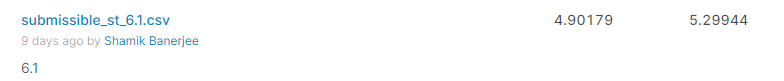

Not plotting the test code as the same eval data is fit here, only change is that entire val data is fit.

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(0), 3049*1913
strategy = 6.1
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = myfeature.get_X_and_y(df, store_name)      # this fun selects rows for given store name, adds more columns, 
                                                # does encoding, returns X and y and encoder
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # following code can be used to predict on 1913 to 1969 to plot true and predict of 1913 to 1941
        # X_train, y_train = X.iloc[3049*(1941-365-365-365):3049*1913], y[3049*(1941-365-365-365):3049*1913]
        # X_test, y_test = X.iloc[3049*1913:], y[3049*1913:]                     
        
        # Original code for fitting, fitiing only on 3 years data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     
    
    if df.id.iloc[0].find('validation') != -1:  # if validation data
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    print('Fitting...')
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

### Training Strategy 5

#### Training Function for 5.1, 5.2

In [ ]:
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = myfeature.get_X_and_y_withou_adding_more_features(df, store_name)
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # X_train, y_train = X.iloc[0:3049*1941], y[:3049*1941]
        # X_test, y_test = X.iloc[3049*1941:], y[3049*1941:]

        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     

    if df.id.iloc[0].find('validation') != -1:  # if validation data
        
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

#### Training strategy 5.1

Instead of LGBRegressor we try XGBRegressor. 
We fit one year data for eval and entire data for val.
We dont add more features than added by feature_engineer() function.

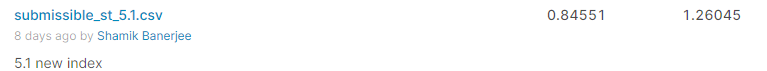

In [ ]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(0), 3049*1913
strategy = 5.1
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

#### Training strategy 5.2

Instead of LGBRegressor we try XGBRegressor. 
We fit entire data for both eval and val. 
We dont add more features than added by feature_engineer() function.

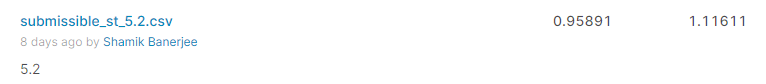

In [ ]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(0), 3049*1941, 3049*(0), 3049*1913
strategy = 5.2
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

#### Training Strategy - 5.3

Instead of LGBRegressor we try XGBRegressor. 
We fit entire data for both eval and val. 
We all the features we can.

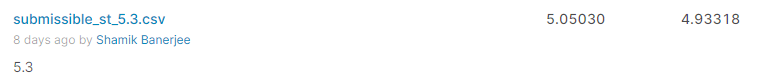

Score - 4.93

In [ ]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(0), 3049*1941, 3049*(0), 3049*1913
strategy = 5.3
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = myfeature.get_X_and_y(df, store_name)      # this fun selects rows for given store name, adds more columns, 
                                                # does encoding, returns X and y and encoder
     
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # X_train, y_train = X.iloc[0:3049*1941], y[:3049*1941]
        # X_test, y_test = X.iloc[3049*1941:], y[3049*1941:]

        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     

    if df.id.iloc[0].find('validation') != -1:  # if validation data
        
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

### Training Strategy 7.5

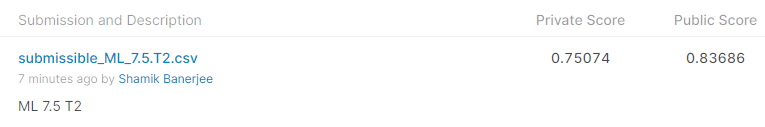

In [ ]:
'''
This function takes input one dept worth of data, it can be from evaluation or validation csv, the function takes care
of that. It fits the model and sends out the labelencoders and predictions. Another function uses the the encoders and 
predictions to roll out final files.
'''

def startegy7dot5T2(new_df, dept):
    print('Using strategy ', strategy)

    evaluation, validation = new_df.id.iloc[0].find('evaluation'), new_df.id.iloc[0].find('validation')
    
    new_df = new_df[new_df.dept_id == dept]
    print('Total rows: ', len(new_df))
    
    rows_per_day = len(new_df[new_df.d == 'd_1'])
    print('Rows per day: ', rows_per_day)
    
    new_df['day_of_month'] = new_df['day_of_month'].fillna(0)
    new_df = new_df.astype({'day_of_month': 'int32'})             # Making day_of_month column as int
    new_df['date'] = new_df['date'].astype(str)

    y = new_df.unit_sale                                          # getting the label
    new_df = new_df.drop('unit_sale', axis=1)

    print('Encoding categorical features...')
    le, new_df = myfeature.encode_cat_cols(new_df)                # Encoding Categorical Columns

    X = new_df
    
    ev_train_start, ev_train_end, val_train_start, val_train_end = rows_per_day*(0), rows_per_day*1941,\
                                                                   rows_per_day*(0), rows_per_day*1913
    
    model = LGBMRegressor(boosting_type = 'gbdt',                 # 7.5 Trial 2
                       objective = 'tweedie',
                       tweedie_variance_power = 1.1,
                       metric = 'rmse',
                       n_estimators = 1207,
                       subsample_freq = 1,
                       learning_rate = 0.04,
                       num_leaves = 2086,
                       reg_lambda = 0.959,
                       min_data_in_leaf = 3942,
                       subsample = 0.37,
                       feature_fraction = 0.95,
                       max_bin = 112,
                       boost_from_average = False)
 
    if evaluation != -1:                                        # if evaluation data
        print('Getting X_train, y_train...')
                                                                
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:] 
        
    if validation != -1:                                        # if validation data
        print('Getting X_train, y_train...')
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    print('X_train len', len(X_train), 'y_train len', len(y_train), 'X_test len', len(X_test))
    
    print('Fitting model...')
    model.fit(X_train, y_train)
    print('Fitting done.')
    
    print('Making predictions...')
    train_out = model.predict(X_test)

    print('Done.')
    return le, X_test, train_out

In [ ]:
'''
This function takes the outputs of individual departments and binds them todgether, retransforms the data back into 
daywise horizontal form, renames the columns as required by kaggle for submission and returns the dataframe that we save as
csv.
'''

def get_output_of_eval_or_val(df):
    main_out_df = pd.DataFrame()
    
    list_dept = list(set(df.dept_id))
    for i in list_dept:
        print('Sequence of depts processing: ', list_dept)
        print('Working on Dept: ', i)
        le, X_test, train_out = startegy7dot5T2(df, i)
        print('Reversing the long form...')
        out_df = myfeature.reverse_long_form(le, X_test, train_out)
        main_out_df = pd.concat([main_out_df, out_df], ignore_index=False)
        cclear()

    l = []                                                         # In this part we rename the columns to F_1, F_2 ....
    for i in range(1,29):
        l.append('F'+str(i))
    l = ['id']+l

    main_out_df.columns = l
    
    return main_out_df

In [ ]:
strategy = 7.5                                            # Setting this variable helps in distinguishing during running

In [ ]:
'''
The next two cells get the output for evaluation.csv data.
'''

In [ ]:
%%time
'''
For evaluation csv, we add columns from 1942 to 1970 so that we can predict. We will need these columns to transform
the data into long form.
Then we use the feature_engineer function to add the features and make the transformation.
'''

df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = myfeature.feature_engineer(df)

In [ ]:
%%time
main_out_df_ev = get_output_of_eval_or_val(df)
main_out_df_ev.to_csv('main_out_ev.csv')

In [ ]:
'''
The next two cells get the output for validation.csv data.
'''

In [ ]:
%%time
'''
For validation csv, we add columns from 1914 to 1942 so that we can predict. We will need these columns to transform
the data into long form.
Then we use the feature_engineer function to add the features and make the transformation.
'''

df = sales_train_val.copy()
empty_list = [0]*30490
for i in range(1914, 1942):
    df['d_'+str(i)] = empty_list
df = myfeature.feature_engineer(df)

In [ ]:
%%time
main_out_df_val = get_output_of_eval_or_val(df)
main_out_df_val.to_csv('main_out_val.csv')

In [ ]:
'''
This part makes sure we have columns in right order, the first column should be item ids.
'''
myfeature.reorder_data(sales_train_val, 'main_out_val')
myfeature.reorder_data(sales_train_ev, 'main_out_ev')

In [ ]:
'''
Making sure there is no unnamed column as that can create problem in submission.
'''
main_out_ev = pd.read_csv('main_out_ev.csv')
main_out_ev = main_out_ev.drop(main_out_ev.columns[0], axis=1)

main_out_val = pd.read_csv('main_out_val.csv')
main_out_val = main_out_val.drop(main_out_val.columns[0], axis=1)

sub_df = pd.concat([main_out_ev, main_out_val], ignore_index=True)
sub_df = sub_df.round(2)

In [ ]:
sub_df.to_csv('submissible_ML_.csv', index=False)

In [ ]:
pd.read_csv('submissible_ML_.csv')

## Steps to train any strategy

In [ ]:
# sequence of stores = CA_1, CA_2, CA_3, CA_4, WI_1, WI_2, WI_3, TX_1, TX_2, TX_3

Training for Evaluation Data

In [ ]:
%%time
df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = myfeature.feature_engineer(df)

main_out_df = myfeature.training_function(df)
main_out_df.to_csv('main_out_ev.csv')
myfeature.reorder_data(sales_train_ev, 'main_out_ev')

Training for Validation Data

In [ ]:
%%time
df = sales_train_val.copy()
empty_list = [0]*30490
for i in range(1914, 1942):
    df['d_'+str(i)] = empty_list
df = myfeature.feature_engineer(df)
main_out_df = myfeature.training_function(df)
main_out_df.to_csv('main_out_val.csv')
myfeature.reorder_data(sales_train_val, 'main_out_val')

Concatenate both CSVs to create the submission csv.

In [ ]:
main_out_ev = pd.read_csv('main_out_ev.csv')
main_out_ev = main_out_ev.drop(main_out_ev.columns[0], axis=1)

main_out_val = pd.read_csv('main_out_val.csv')
main_out_val = main_out_val.drop(main_out_val.columns[0], axis=1)

sub_df = pd.concat([main_out_ev, main_out_val], ignore_index=True)
sub_df = sub_df.round(2)                            # We round the float values till 2nd decimal places  

# we only keep absolute values
ll = sub_df['id']
sub_df = sub_df.drop('id', axis=1)
for i in list(sub_df.columns):
    sub_df[i] = sub_df[i].abs()

# sub_df = sub_df.round(0).astype(int)    

# sub_df.select_dtypes(exclude=['object' ]) * 1.5
sub_df['id'] = ll

cols = list(sub_df)
cols = [cols[-1]] + cols[:-1]
sub_df = sub_df[cols]
sub_df
    
sub_df.to_csv('submissible_st_5.3.csv', index = False)

### Submission CSV

In [ ]:
# sub_df = pd.read_csv('submissible_st_5.3.csv')
# sub_df